# Loading in processed ice divide data
By George Lu

Last updated March 28, 2025

For now, let's just load in the inversion results (i.e. not $w_{eff}$)

In [1]:
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.stats import linregress
import matplotlib.colors as colors
from scipy.io import loadmat 


In [2]:
from scipy.io import loadmat
from scipy.io.matlab.mio5_params import mat_struct

def mat_struct_to_dict(mat_obj):
    """Recursively convert mat_struct objects to nested dictionaries."""
    data = {}
    for fieldname in mat_obj._fieldnames:
        elem = getattr(mat_obj, fieldname)
        if isinstance(elem, mat_struct):
            data[fieldname] = mat_struct_to_dict(elem)
        else:
            data[fieldname] = elem
    return data

def load_mat_file(filepath):
    """Load a .mat file and handle mat_struct conversion."""
    mat_data = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    
    data_dict = {}
    for key, value in mat_data.items():
        if isinstance(value, mat_struct):
            data_dict[key] = mat_struct_to_dict(value)
        else:
            data_dict[key] = value

    return data_dict

/var/folders/q5/9bzlkvcx1glgh6zpxpsqsmm40000gn/T/ipykernel_8710/3665967524.py:2: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.io.matlab.mio5_params import mat_struct


In [76]:
mat = load_mat_file('Process_Ronne_pRES/KFResults_gammaDx_x=15_nIter=10000.mat')
x = mat['xTrue']
z = mat['zTrue']
u = mat['uTrue'] # for comparison, and for surface bondary condition
w = mat['wTrue'] # only w is known throughout
rho = mat['RhoTrue'] # for basal boundary condition
p = np.zeros(x.shape) # for surface boundary condition

# Constants
rho = 910  # Ice density (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)
sec_per_year = 365.25 * 24 * 60 * 60  # Seconds per year

# Surface and bed
z_surf = z[:, -1]  # Surface elevation (shape: 101,)
x_surf = x[:, -1]
z_bed = z[:,0]
#x_flanks = np.array([x[0, :], x[-1, :]])  # x coordinates of left and right flanks

# Slopes
dsdx = np.gradient(z_surf) / np.gradient(x_surf)
slope_at_flank = np.array([dsdx[0], dsdx[-1]])

# Get u and z at flanks
u_left = u[0, :]  # u at left flank
u_right = u[-1, :]  # u at right flank
z_left = z[0, :]  # z values at left flank
z_right = z[-1, :]  # z values at right flank

# Calculate du/dz at flanks
dudz_left = np.gradient(u_left) / np.gradient(z_left) / sec_per_year
dudz_right = np.gradient(u_right) / np.gradient(z_right) / sec_per_year

# Depth at flanks
flank_depth_left = z_surf[0] - z_bed[0]  # Depth at left flank
flank_depth_right = z_surf[-1] - z_bed[-1]  # Depth at right flank
flank_depth = np.array([flank_depth_left, flank_depth_right])

# Broadcast slope to same shape as depth
broadcast_slope = np.tile(slope_at_flank[:, np.newaxis], (1, 101))

# Estimate effective viscosity mu at flanks
mu_left = -slope_at_flank[0] * rho * g * flank_depth[0] / dudz_left
mu_right = -slope_at_flank[1] * rho * g * flank_depth[1] / dudz_right

# Tile to full shape (101, 101) to match original arrays
#mu = np.vstack([np.tile(mu_left[:, np.newaxis], (1, 101)), np.tile(mu_right[:, np.newaxis], (1, 101))])
mu_empty = np.zeros(x.shape)
mu_empty[0,:] = mu_left
mu_empty[-1,:] = mu_right
mu=mu_empty

dict_full = {}
dict_surf = {}
dict_flanks = {}
dict_bed = {}
dict_divide = {}

for key, var in zip(['x','z','u','w','rho','p','mu'],[x,z,u,w,rho,p,mu]):
    dict_full['key']=var
    dict_surf['key']=var[:,-1]
    

TypeError: 'int' object is not subscriptable

In [79]:
mu[0,:]

array([ 2.40008815e+13,  1.28981821e+14, -5.41012529e+13, -1.91726203e+14,
        4.77336786e+15, -3.62185050e+15,  1.33210979e+16,  5.80191671e+14,
        3.53372378e+14,  5.15820455e+14,  3.17754591e+15, -1.41745912e+15,
       -1.52992464e+15,  2.96821274e+14,  6.58184488e+13,  2.86610565e+13,
        2.30546303e+13,  1.04806173e+14, -4.73109901e+13, -7.76497729e+14,
        2.90416188e+13,  3.59101159e+13, -3.97924391e+13, -1.77177261e+13,
       -2.61064410e+13, -1.70029458e+14,  5.20406844e+13,  3.98117511e+13,
       -1.76145250e+14, -4.38933228e+13,  1.51084524e+14,  3.95282605e+13,
        2.39277451e+14, -1.66201719e+14,  6.98091376e+13,  4.77719798e+14,
       -4.18179267e+13, -8.03954446e+13,  8.80867087e+14, -1.18754374e+15,
       -1.61836739e+15,  2.06491305e+14,  1.99235031e+14, -5.00353911e+14,
       -2.52318749e+14,  2.19967664e+15, -1.34082964e+15, -3.24946534e+14,
        1.84741336e+14,  5.09867958e+13,  9.56855446e+13, -5.51131526e+13,
       -4.80857571e+13,  

In [34]:
# for mu, need SIA approx
# slope at flanks:
z_surf = z[:,-1]
x_surf = x[:,-1]

slopes = np.gradient(z_surf)/np.gradient(x_surf)
slope_left = slopes[0]
slope_right = slopes[-1]

In [37]:
z_surf.shape

(101,)

In [47]:
test = np.tile(z_surf,(101,1))

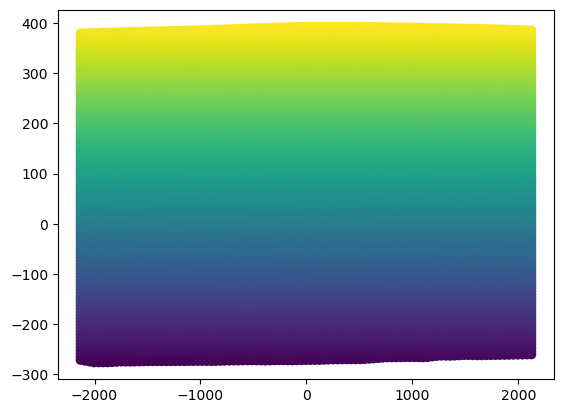

In [54]:
plt.scatter(x,z,c=z)